# Using chef in jupyter notebook

To run chef in the notebook, use the `Chef` class from `ddf_utils.chef.api`

In [5]:
import os
import sys
import ruamel.yaml as yaml
from ddf_utils.chef.api import Chef

In [15]:
# at the beginning, initial the chef
chef = Chef()

In [16]:
# adding configs and metadata(to the info section)

(chef.add_config(ddf_dir=os.path.expanduser('~/src/work/Gapminder'))
     .add_metadata(id='test_dataset', 
                   base=['ddf--transpint--corrupton']))

In [17]:
# adding ingredient, parameters are just like in recipe

i = '''
id: cpi-datapoints
dataset: ddf--transpint--corrupton
key: country, year
value: "*"
'''

d = yaml.round_trip_load(i)
chef.add_ingredient(**d)

In [18]:
# add an other ingredient

chef.add_ingredient(id='bp-datapoints', dataset='ddf--bp--energy', key='geo, year', value='*')

In [19]:
# add procedures, parameters are same as in recipe

chef.add_procedure(collection='datapoints',   # which part of cooking section the procedure is in
                   procedure='translate_header', 
                   ingredients=['bp-datapoints'], 
                   result='bp-datapoints-translate', 
                   options={'dictionary': {'geo': 'country'}})

In [20]:
# add an other procedure

chef.add_procedure(collection='datapoints', 
                   procedure='merge', 
                   ingredients=['bp-datapoints-translate', 'cpi-datapoints'], 
                   result='res')

In [21]:
# you can print the recipe in yaml format

chef.to_recipe()

info:
  id: test_dataset
  base:
  - ddf--transpint--corrupton
config:
  ddf_dir: /Users/semio/src/work/Gapminder
ingredients:
- id: cpi-datapoints
  dataset: ddf--transpint--corrupton
  key: country, year
  values: '*'
- id: bp-datapoints
  dataset: ddf--bp--energy
  key: geo, year
  values: '*'
cooking:
  datapoints:
  - procedure: translate_header
    ingredients:
    - bp-datapoints
    options:
      dictionary:
        geo: country
    result: bp-datapoints-translate
  - procedure: merge
    ingredients:
    - bp-datapoints-translate
    - cpi-datapoints
    result: res


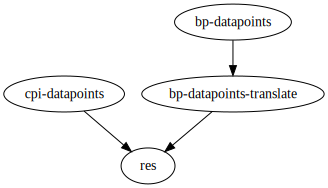

In [22]:
# also in graph

chef.to_graph()

In [23]:
# to run the recipe and get the output:

res = chef.run()

In [24]:
res

[<ProcedureResult: res>]

In [25]:
res[0].get_data().keys()

dict_keys(['biofuels_production_kboed', 'biofuels_production_ktoe', 'carbon_dioxide_emissions', 'coal_consumption_mtoe', 'coal_production_mtoe', 'coal_production_tonnes', 'electricity_generation', 'gas_consumption_bcf', 'gas_consumption_bcm', 'gas_consumption_tonnes', 'gas_production_bcf', 'gas_production_bcm', 'gas_production_tonnes', 'gas_proved_reserves_history', 'geo_biomass_other_mtoe', 'geo_biomass_other_twh', 'hydro_consumption_mtoe', 'hydro_consumption_twh', 'nuclear_consumption_mtoe', 'nuclear_consumption_twh', 'oil_consumption_barrels', 'oil_consumption_tonnes', 'oil_production_barrels', 'oil_production_tonnes', 'oil_proved_reserves_history', 'oil_refinery_capacities', 'oil_refinery_throughput', 'other_renewables_mtoe', 'other_renewables_twh', 'primary_energy_consumption', 'solar_consumption_mtoe', 'solar_consumption_twh', 'wind_consumption_mtoe', 'wind_consumption_twh', 'cpi'])

In [29]:
res[0].get_data()['biofuels_production_kboed'].sample(5)

,country,year,biofuels_production_kboed
258,france,2014,52.2690
823,total_world,2007,696.8200
530,portugal,2000,0.0000
565,south_korea,2009,6.8967
771,total_north_america,2007,279.5600


In [30]:
res[0].get_data()['cpi'].sample(5)

,country,year,cpi
675,civ,2011,2.233704
1011,nic,2013,28.000000
795,zmb,2012,37.000000
574,kwt,2011,4.616031
137,kgz,2014,27.000000


In [32]:
# we can also create a Chef instance from existing recipes

recipe_file = '../tests/recipes_pass/test_flatten.yml'
print(open(os.path.expandvars(recipe_file)).read())

info:
    id: test-flatten


ingredients:
    - id: cme-datapoints
      dataset: ddf--cme
      key: "country,year"
      value: "*"



cooking:
    datapoints:
        - procedure: filter_row
          ingredients:
              - cme-datapoints
          result: filtered
          options:
              filters:
                imr_lower:
                    country: afg
                    year:
                        - 1990
                        - 1991
                imr_upper:
                    country:
                        - usa
                        - swe
                    year:
                        - 1990
                        - 1991
                        - 1992
                        - 1993
                        - 1994
                        - 1995
                        - 1996
        - procedure: flatten
          ingredients:
              - filtered
          options:
              dictionary:
                  "imr*": "{concept}_{country}"
      

In [33]:
chef = Chef.from_recipe(os.path.expandvars(recipe_file))

no serve procedure found, serving the last result: res


In [34]:
chef.add_config(ddf_dir='../tests/datasets/')

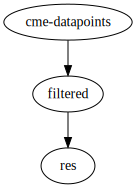

In [35]:
chef.to_graph()

In [36]:
res = chef.run()

In [37]:
res[0].get_data().keys()

dict_keys(['imr_lower_afg', 'imr_upper_swe', 'imr_upper_usa'])

In [41]:
res[0].get_data()['imr_lower_afg']

,year,imr_lower_afg
29,1990,111.6
30,1991,108.0


# Advance usage: create new procedure

will add description later

In [42]:
from ddf_utils.chef.ingredient import Ingredient, ProcedureResult

In [58]:
def multiply_1000(dag, ingredients, result, **options):
    ingredients = [dag.get_node(x) for x in ingredients]
    ingredient = ingredients[0].evaluate()
    
    new_data = dict()
    for k, df in ingredient.get_data().items():
        df_ = df.copy()
        df_[k] = df_[k] * 1000
        new_data[k] = df_
        
    return ProcedureResult(result, ingredient.key, new_data)

In [44]:
chef = Chef()
chef.add_config(ddf_dir=os.path.expanduser('~/src/work/Gapminder'))

In [45]:
i = '''
id: cpi-datapoints
dataset: ddf--transpint--corrupton
key: country, year
value: "*"
'''

d = yaml.round_trip_load(i)
chef.add_ingredient(**d)

In [59]:
chef.register_procedure(multiply_1000)

In [49]:
chef.add_procedure(collection='datapoints',
                   procedure='multiply_1000',
                   result='res',
                   ingredients=['cpi-datapoints']
                  )

In [61]:
res = chef.run()

In [65]:
res[0].get_data()['cpi'].head(5)

,country,year,cpi
0,dnk,2014,92000.0
1,nzl,2014,91000.0
2,fin,2014,89000.0
3,swe,2014,87000.0
4,nor,2014,86000.0


In [64]:
chef.ingredients

[<Ingredient: cpi-datapoints>]

In [66]:
chef.ingredients[0].get_data()['cpi'].head()  # the original

,country,year,cpi
0,dnk,2014,92.0
1,nzl,2014,91.0
2,fin,2014,89.0
3,swe,2014,87.0
4,nor,2014,86.0
